In [36]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import os
from newspaper import Article
from konlpy.tag import Hannanum,Kkma,Komoran,Mecab,Okt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [8]:
# Takes page number, category, and date as input. 
# 100 : Politics, 101 :Economics, 102' : 'Society, 103: Lifestyle/Culture, 104 : Worldwise, 105 : IT/Science, 110 : Opinion

def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)   
    news = requests.get(url)

    # Create BeautifulSoup instance with html.parser.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # Retrieve address from <a href ='address'> 
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [13]:
# This is a function that generates dataframe.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.text)

  #- Set values to the text under the key 'news' in the dataframe.
  df = pd.DataFrame({'news': text_list})

  #- Put category names under the key 'code' in the dataframe.
  df['code'] = idx2word[str(code)]
  return df

In [2]:
idx2word = {'101' : 'Economics', '102' : 'Society', '103' : 'Lifestyle/Culture', '105' : 'IT/Science'}
code_list = [102, 103, 105]

In [3]:
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print('Code '+str(code)+' is processed to data')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [14]:
df = make_total_data(1, code_list, 20200802) # 20 news per page, so 60 news in total.

Code 102 is processed to data
Code 103 is processed to data
Code 105 is processed to data


In [50]:
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df = pd.read_table(csv_path, sep=',')
#df.tail(10)
print(df['news'])

0       파주시청. 사진제공=파주시 파주시청. 사진제공=파주시\n\n[파주=파이낸셜뉴스 강근...
1       동영상 뉴스\n\n이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의...
2       황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검. 사진...
3       귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...
4       (서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...
                              ...                        
5119    신종 코로나바이러스 감염증(코로나19) 사태 이후 ‘가정의 달’ 5월에도 언택트(비...
5120    는 소비자로부터 월 이용료 1만~2만원을 받고 초고속 인터넷을 제공한다. 그런 SK...
5121    머리를 긁고 있는 오랑우탄. 몸을 긁는 행동을 따라 하는 것은 부정적 감정과 관련이...
5122    가 오는 15일 정식 출시하는 스마트폰 'LG벨벳'이 사실상 '공짜폰'이 될 전망이...
5123    이미지제공=게티이미지뱅크 이미지제공=게티이미지뱅크\n\n[Copyright ⓒ 전자...
Name: news, Length: 5124, dtype: object


In [16]:
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # Remove characters other than Korean using regular expression. 

In [17]:
# Check if null data is in the sample.
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [18]:
# Remove every duplicated sample.
df.drop_duplicates(subset=['news'], inplace=True)
print('Number of news after removal process: ',len(df))

Number of news after removal process:  3994


                code  count
0         IT/Science    903
1  Lifestyle/Culture   1423
2            Society   1668


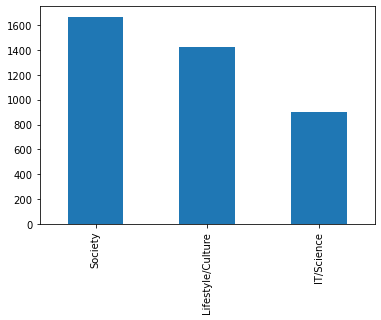

In [19]:
df['code'].value_counts().plot(kind = 'bar')
print(df.groupby('code').size().reset_index(name = 'count'))

In [37]:
tokenizer1 = Hannanum()
tokenizer2 = Kkma()
tokenizer3 = Komoran()
tokenizer4 = Mecab()
tokenizer5 = Okt()
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [61]:
# Tokenise and discard stopwords.
class preprocessing:
    
    def Hannanum(self, data):
      text_data = []

      for sentence in data:
        temp_data = []
        #- Tokenise
        temp_data = tokenizer1.morphs(sentence) 
        #- discard stopwords
        temp_data = [word for word in temp_data if not word in stopwords] 
        text_data.append(temp_data)

      text_data = list(map(' '.join, text_data))

      return text_data
    
    def Kkma(self, data):
      text_data = []

      for sentence in data:
        temp_data = []
        #- Tokenise
        temp_data = tokenizer2.morphs(sentence) 
        #- discard stopwords
        temp_data = [word for word in temp_data if not word in stopwords] 
        text_data.append(temp_data)

      text_data = list(map(' '.join, text_data))

      return text_data

    def Komoran(self, data):
      text_data = []

      for sentence in data:
        temp_data = []
        #- Tokenise
        temp_data = tokenizer3.morphs(sentence) 
        #- discard stopwords
        temp_data = [word for word in temp_data if not word in stopwords] 
        text_data.append(temp_data)

      text_data = list(map(' '.join, text_data))

      return text_data
    
    def Mecab(self, data):
      text_data = []

      for sentence in data:
        temp_data = []
        #- Tokenise
        temp_data = tokenizer4.morphs(sentence) 
        #- discard stopwords
        temp_data = [word for word in temp_data if not word in stopwords] 
        text_data.append(temp_data)

      text_data = list(map(' '.join, text_data))

      return text_data
    
    def Okt(self, data):
      text_data = []

      for sentence in data:
        temp_data = []
        #- Tokenise
        temp_data = tokenizer5.morphs(sentence) 
        #- discard stopwords
        temp_data = [word for word in temp_data if not word in stopwords] 
        text_data.append(temp_data)

      text_data = list(map(' '.join, text_data))

      return text_data
print(df.shape)

(5124, 2)


In [62]:
preprocess = preprocessing()
text_data1 = preprocess.Hannanum(df['news'])
text_data2 = preprocess.Kkma(df['news'])
text_data3 = preprocess.Komoran(df['news'])
text_data4 = preprocess.Mecab(df['news'])
text_data5 = preprocess.Okt(df['news'])
print(text_data1[0])

파주시청 . 사진제공=파주시 파주시청 . 사진제공 = 파주시 [파주=파이낸셜뉴스 강근주 기 자 ] 파 아 주 시는 4일 관내 취약계층 1만9379가구 대 어 어 정부 긴급재난지원금 입금 완료 었다 . 파주시민 받 긴급재난지원금 ‘4 ㄴ 이상 가구’ 기준 으로 87만1000원 받 게 되 며 , 3 ㄴ 가구 69만7000원 , 2 ㄴ 가구 52만3000원 , 1 ㄴ 가구 34만8000원 . 정부 발표 ㄴ 긴급재난지원금 파주시민 지급 ㄴ 금액 다르 ㄴ 이유 국비 - 지방비 부담 비율 . 파주시 이미 모든 시민 ‘경기도-파주시 재난기본소득’(1인당 각 10만원 ) 지급 하고 어 시민 국비 지원금 만 지급 며 4 ㄴ 가구 기준 으로 총 지원 금액 ‘파주시 재난기본소득’ 40만원 , ‘경기 도 재난기본소득’ 40만원 , ‘정부 긴급재난지원금’ 87만1000원 총 167만1000원 받 게 되 ㄴ다 . 취약계층 아니 ㄴ 시민 오 5월11일부터 소 지 하고 신 용 · 체크카드사 홈페이지 에서 긴급재난지원금 지원 신청 ㄹ . 세대주 가족 지원금 일괄 신청 어야 ㄴ다 . 한편 파 아 주 시는 3일 김정기 부시장 단장 으로 ‘긴급재난지원금 추진 태스크포스’ 를 구성해 긴급재난지원금 원활 게 지급 되 ㄹ 도록 지원 ㄴ다 . ※ 저작권자 ⓒ 파이낸셜뉴스 . - 재배포


In [72]:
# Data partition
X_train1, X_test1, y_train1, y_test1 = train_test_split(text_data1, df['code'], test_size = 0.2, random_state = 0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(text_data2, df['code'], test_size = 0.2, random_state = 0)
X_train3, X_test3, y_train3, y_test3 = train_test_split(text_data3, df['code'], test_size = 0.2, random_state = 0)
X_train4, X_test4, y_train4, y_test4 = train_test_split(text_data4, df['code'], test_size = 0.2, random_state = 0)
X_train5, X_test5, y_train5, y_test5 = train_test_split(text_data5, df['code'], test_size = 0.2, random_state = 0)

In [73]:
#- Count vectoriser which counts the number of words.(Like TF)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- Receive TF-IDF from the result of count vectoriser.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


#- Execute Naive bayes classifier.
#- X_train : TF-IDF vector, y_train : label.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [74]:
# Processing function which automatically converts into TF-IDF.
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [71]:
text1 = ["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."]
Hannanum_text1 = preprocess.Hannanum(text1)
Kkma_text1 = preprocess.Kkma(text1)
Komoran_text1 = preprocess.Komoran(text1)
Mecab_text1 = preprocess.Mecab(text1)
Okt_text1 = preprocess.Okt(text1)

print('Hannanum result: ', clf.predict(tfidf_vectorizer(Hannanum_text1)))
print('Kkma result: ', clf.predict(tfidf_vectorizer(Kkma_text1)))
print('Komoran result: ', clf.predict(tfidf_vectorizer(Komoran_text1)))
print('Mecab result: ', clf.predict(tfidf_vectorizer(Mecab_text1)))
print('Okt result: ', clf.predict(tfidf_vectorizer(Okt_text1)))



Hannanum result:  ['Society']
Kkma result:  ['Society']
Komoran result:  ['Society']
Mecab result:  ['Society']
Okt result:  ['Society']


In [77]:
text2 = preprocess.Hannanum(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
Hannanum_text2 = preprocess.Hannanum(text2)
Kkma_text2 = preprocess.Kkma(text2)
Komoran_text2 = preprocess.Komoran(text2)
Mecab_text2 = preprocess.Mecab(text2)
Okt_text2 = preprocess.Okt(text2)

print('Hannanum result: ', clf.predict(tfidf_vectorizer(Hannanum_text2)))
print('Kkma result: ', clf.predict(tfidf_vectorizer(Kkma_text2)))
print('Komoran result: ', clf.predict(tfidf_vectorizer(Komoran_text2)))
print('Mecab result: ', clf.predict(tfidf_vectorizer(Mecab_text2)))
print('Okt result: ', clf.predict(tfidf_vectorizer(Okt_text2)))

Hannanum result:  ['Lifestyle/Culture']
Kkma result:  ['Lifestyle/Culture']
Komoran result:  ['Lifestyle/Culture']
Mecab result:  ['Lifestyle/Culture']
Okt result:  ['Lifestyle/Culture']


In [79]:
text3 = preprocess.Hannanum(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
Hannanum_text3 = preprocess.Hannanum(text3)
Kkma_text3 = preprocess.Kkma(text3)
Komoran_text3 = preprocess.Komoran(text3)
Mecab_text3 = preprocess.Mecab(text3)
Okt_text3 = preprocess.Okt(text3)

print('Hannanum result: ', clf.predict(tfidf_vectorizer(Hannanum_text3)))
print('Kkma result: ', clf.predict(tfidf_vectorizer(Kkma_text3)))
print('Komoran result: ', clf.predict(tfidf_vectorizer(Komoran_text3)))
print('Mecab result: ', clf.predict(tfidf_vectorizer(Mecab_text3)))
print('Okt result: ', clf.predict(tfidf_vectorizer(Okt_text3)))

Hannanum result:  ['IT/Science']
Kkma result:  ['IT/Science']
Komoran result:  ['IT/Science']
Mecab result:  ['IT/Science']
Okt result:  ['IT/Science']


In [83]:
y_pred1 = clf.predict(tfidf_vectorizer(X_test1))
y_pred2 = clf.predict(tfidf_vectorizer(X_test2))
y_pred3 = clf.predict(tfidf_vectorizer(X_test3))
y_pred4 = clf.predict(tfidf_vectorizer(X_test4))
y_pred5 = clf.predict(tfidf_vectorizer(X_test5))

print('1.Hannanum report: \n', metrics.classification_report(y_test1, y_pred1))
print('2.Kkma report: \n', metrics.classification_report(y_test2, y_pred2))
print('3.Komoran report: \n', metrics.classification_report(y_test3, y_pred3))
print('4.Mecab report: \n', metrics.classification_report(y_test4, y_pred4))
print('5.Okt report: \n', metrics.classification_report(y_test5, y_pred5))

1.Hannanum report: 
                    precision    recall  f1-score   support

       IT/Science       0.92      0.86      0.89       273
Lifestyle/Culture       0.88      0.81      0.84       336
          Society       0.83      0.92      0.87       416

         accuracy                           0.87      1025
        macro avg       0.88      0.86      0.87      1025
     weighted avg       0.87      0.87      0.87      1025

2.Kkma report: 
                    precision    recall  f1-score   support

       IT/Science       0.92      0.78      0.84       273
Lifestyle/Culture       0.82      0.80      0.81       336
          Society       0.80      0.90      0.85       416

         accuracy                           0.84      1025
        macro avg       0.85      0.83      0.84      1025
     weighted avg       0.84      0.84      0.84      1025

3.Komoran report: 
                    precision    recall  f1-score   support

       IT/Science       0.92      0.81      0.86  